# Project on recommander systems : Third Environmement

#### Author : Raymond KUOCH and Alexandre MAXINSANG

In [21]:
import requests
import time
import numpy as np
import pandas as pd
import copy
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dropout, Dense
from keras.models import Model
from keras.utils import plot_model
from IPython.display import Image

## Get The Data

In [22]:
#attributes 
USER_ID = 'IAHIZPIW80WPGDW7P7JE'
BASE_URL = "http://35.180.178.243"
url_reset = BASE_URL + "/reset"
url_predict = BASE_URL + "/predict"
params = {"user_id" : USER_ID}

def load_data(url_reset,params) :
    r = requests.get(url=url_reset, params=params)
    data = r.json()
    return data

data = load_data(url_reset,params)
nb_users = data["nb_users"]
nb_items = data["nb_items"]
next_state = data["next_state"]

data.keys()

dict_keys(['action_history', 'nb_items', 'nb_users', 'next_state', 'rewards_history', 'state_history'])

In [23]:
blacklisted_set = set(("next_state","nb_items","nb_users"))
new_dict = {key : value for key, value in data.items() if key not in blacklisted_set}

df = pd.DataFrame(new_dict)
df.head()

,action_history,rewards_history,state_history
0,28,0.0,"[[57, 0, 595.5589812294365, 2.2104000009091296..."
1,8,0.0,"[[25, 0, 595.5589812294365, 0.7259989606922315..."
2,13,0.0,"[[7, 0, 595.5589812294365, 0.2868925874749695,..."
3,6,0.0,"[[5, 0, 595.5589812294365, 0.6805394464272617,..."
4,15,0.0,"[[38, 0, 595.5589812294365, -0.162961215932765..."


In [24]:
df.describe()

,action_history,rewards_history
count,200.000000,200.000000
mean,15.650000,155.224434
std,8.457253,289.226499
min,0.000000,0.000000
25%,8.000000,0.000000
50%,16.000000,0.000000
75%,23.000000,210.925374
max,29.000000,952.954752


In [25]:
df[df['rewards_history']==0].count()

action_history     146
rewards_history    146
state_history      146
dtype: int64

In [26]:
users_items_df = []
for i in range(df.shape[0]):
    users_items_df += df['state_history'][i] 
    
users_items_df = pd.DataFrame(users_items_df,columns = ['user_id','item_id',
                                                        'price','v1','v2','v3','v4','v5'])
users_items_df

,user_id,item_id,price,v1,v2,v3,v4,v5
0,57,0,595.558981,2.210400,0.716863,-0.029725,0.694641,0.586458
1,57,1,560.926693,2.210400,0.716863,1.371444,2.729901,2.488792
2,57,2,761.681819,2.210400,0.716863,1.489899,0.627743,0.723046
3,57,3,952.954752,2.210400,0.716863,0.599575,0.174847,1.822831
4,57,4,536.009550,2.210400,0.716863,1.681701,0.911114,2.376639
5,57,5,269.758611,2.210400,0.716863,1.565109,1.721343,0.381009
6,57,6,913.306167,2.210400,0.716863,0.260949,1.850783,0.623935
7,57,7,866.778063,2.210400,0.716863,2.370065,0.337394,1.388099
8,57,8,453.899690,2.210400,0.716863,0.705133,1.385218,1.557713
9,57,9,382.420752,2.210400,0.716863,-0.531920,-0.859419,0.470211


In [27]:
# Eliminate the 'v5'
new_users_items_df = users_items_df.drop(columns='v5').drop_duplicates() 

In [28]:
# We can see that the first two covariates variables are features about users 
# and the forth and fifth variable are features about items
# The variable 5 depends on .....

user_v1 = users_items_df['v1'].unique()
user_v2 = users_items_df['v2'].unique()
users_ids = users_items_df['user_id'].unique()
users_content= pd.DataFrame({'user_id' : users_ids,'v1':user_v1,'v2':user_v2 })

item_v3 = users_items_df['v3'].unique()
item_v4 = users_items_df['v4'].unique()
item_id = users_items_df['item_id'].unique()
items_content= pd.DataFrame({'item_id' : item_id,'v3':item_v3,'v4':item_v4 })

In [29]:
# We don't have all the metadat from all the users
users_content['user_id'].unique().shape

(86,)

## Data Preprocessing

In [30]:
pos_df = df[df["rewards_history"] > 0].reset_index(drop=True)
neg_df = df[df["rewards_history"] == 0].reset_index(drop=True)

In [31]:
pos_df["user_id"] = [pos_df["state_history"][i][0][0] for i in range(pos_df.shape[0])]
pos_df["item_id_action"] = [pos_df["state_history"][i][pos_df["action_history"][i]][1] for i in range(pos_df.shape[0])]
pos_df.head()## There are some users that have more than one positive item

,action_history,rewards_history,state_history,user_id,item_id_action
0,18,465.735267,"[[95, 0, 595.5589812294365, 1.2112675037571996...",95,18
1,27,865.631584,"[[18, 0, 595.5589812294365, 0.0968397267315899...",18,27
2,23,407.813962,"[[91, 0, 595.5589812294365, 1.786253558328159,...",91,23
3,25,672.661051,"[[50, 0, 595.5589812294365, 1.8900834646846807...",50,25
4,6,913.306167,"[[50, 0, 595.5589812294365, 1.8900834646846807...",50,6


In [32]:
neg_df["user_id"] = [neg_df["state_history"][i][0][0] for i in range(neg_df.shape[0])]
neg_df["item_id_action"] = [neg_df["state_history"][i][neg_df["action_history"][i]][1] for i in range(neg_df.shape[0])]
neg_df.head()

,action_history,rewards_history,state_history,user_id,item_id_action
0,28,0.0,"[[57, 0, 595.5589812294365, 2.2104000009091296...",57,28
1,8,0.0,"[[25, 0, 595.5589812294365, 0.7259989606922315...",25,8
2,13,0.0,"[[7, 0, 595.5589812294365, 0.2868925874749695,...",7,13
3,6,0.0,"[[5, 0, 595.5589812294365, 0.6805394464272617,...",5,6
4,15,0.0,"[[38, 0, 595.5589812294365, -0.162961215932765...",38,15


# Models

In [33]:
import tensorflow as tf

def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred + 0 * y_true)


def margin_comparator_loss(inputs, margin=1.):
    """Comparator loss for a pair of precomputed similarities
    
    If the inputs are cosine similarities, they each have range in
    (-1, 1), therefore their difference have range in (-2, 2). Using
    a margin of 1. can therefore make sense.

    If the input similarities are not normalized, it can be beneficial
    to use larger values for the margin of the comparator loss.
    """
    positive_pair_sim, negative_pair_sim = inputs
    return tf.maximum(negative_pair_sim - positive_pair_sim + margin, 0)

## Naive Model(The most expensive item)

In [34]:
def naive_model_expensive(state):
    greater_index = 0
    greater_value = 0
    
    for i in range(len(state)):
        if(state[i][2] > greater_value):
            greater_value = state[i][2]
            greater_index = i
    return greater_index  

In [35]:
number_run = 3
generations = 1000
total_reward = 0
params = {"user_id" : USER_ID}

for k in range(number_run):
    
    for i in range(generations):

        predicted_item = naive_model_expensive(next_state)

        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward
        next_state = r['state']
        
        
print("Total reward: %f and Total reward per run: %f"%(total_reward, total_reward/number_run,))

Total reward: 618310.286236 and Total reward per run: 206103.428745


## Naive Model(The cheapest item)

In [36]:
def naive_model_cheapest(state):
    cheapest_index = 0
    cheapest_value =  state[0][2]
    
    for i in range(len(state)):
        if(state[i][2] < cheapest_value):
            cheapest_value = state[i][2]
            cheapest_index = i
            
    return cheapest_index  

In [37]:
number_run = 3
generations = 1000
total_reward = 0
params = {"user_id" : USER_ID}

for k in range(number_run):
    
    for i in range(generations):

        predicted_item = naive_model_cheapest(next_state)

        params['recommended_item'] = predicted_item

        r = requests.get(url = url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward
        next_state = r['state']
        
        
print("Total reward: %f and Total reward per run: %f"%(total_reward, total_reward/number_run,))

Total reward: 140887.362201 and Total reward per run: 46962.454067


## Model 1 (without covariates)

In [38]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense
from keras.layers import Lambda, Dot
from keras.regularizers import l2
from keras.layers.merge import dot, concatenate


def build_models(n_users, n_items, latent_dim=64, l2_reg=0):
    """Build a triplet model and its companion similarity model
    
    The triplet model is used to train the weights of the companion
    similarity model. The triplet model takes 1 user, 1 positive item
    (relative to the selected user) and one negative item and is
    trained with comparator loss.
    
    The similarity model takes one user and one item as input and return
    compatibility score (aka the match score).
    """
    # Common architectural components for the two models:
    # - symbolic input placeholders
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')

    # - embeddings
    l2_reg = None if l2_reg == 0 else l2(l2_reg)
    user_layer = Embedding(input_dim=n_users + 1, output_dim=latent_dim, input_length=1,
                           name='user_embedding', embeddings_regularizer=l2_reg)
    
    # The following embedding parameters will be shared to encode both
    # the positive and negative items.
    item_layer = Embedding(input_dim=n_items + 1, output_dim=latent_dim, input_length=1,
                           name="item_embedding", embeddings_regularizer=l2_reg)

    user_embedding = Flatten()(user_layer(user_input))
    positive_item_embedding = Flatten()(item_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_layer(negative_item_input))

    # - similarity computation between embeddings
    positive_similarity = Dot(name="positive_similarity",
                              axes=1, normalize=True)(
        [user_embedding, positive_item_embedding])
    negative_similarity = Dot(name="negative_similarity",
                              axes=1, normalize=True)(
        [user_embedding, negative_item_embedding])

    # The triplet network model, only used for training
    triplet_loss = Lambda(margin_comparator_loss,
                          name='comparator_loss',
                          output_shape=(1,))([positive_similarity, negative_similarity])

    triplet_model = Model(inputs=[user_input,
                                  positive_item_input,
                                  negative_item_input],
                          outputs=triplet_loss)
    
    # The match-score model, only use at inference to rank items for a given
    # model: the model weights are shared with the triplet_model therefore
    # we do not need to train it and therefore we do not need to plug a loss
    # and an optimizer.
    match_model = Model(inputs=[user_input, positive_item_input],
                        outputs=positive_similarity)
    
    return triplet_model, match_model


In [39]:
def sample_triplets(pos_df,max_items):
    """
    Sample negatives at random
    
    """
    range_itens = np.arange(max_items)
    user_ids = pos_df['user_id'].values
    pos_item_ids = pos_df['item_id_action'].values
    
    
    user_pos_items = pos_df.groupby('user_id')['item_id_action'].apply(list)
    neg_item_ids = np.array([])
    for i in user_ids:
        if i in set(user_pos_items.index):
            number = np.random.choice([item for item in range_itens 
                                       if not item in user_pos_items[user_pos_items.index == i]])
        else:
            number = np.random.choice(range_itens,1)
        neg_item_ids = np.append(neg_item_ids,number)
    
  
    return [user_ids, pos_item_ids, neg_item_ids]

In [40]:
number_run = 3
n_epochs = 1
total_reward = 0
generations = 1000
max_items = 30


for k in range(number_run):

    triplet_model, match_model = build_models(nb_users, nb_items, latent_dim=16, l2_reg=1e-6)
    # we plug the identity loss and the a fake target variable ignored by
    # the model to be able to use the Keras API to train the triplet model
    triplet_model.compile(loss=identity_loss, optimizer="adam")
    fake_y = np.ones_like(pos_df['user_id'])
    params = {'user_id': USER_ID}

    positive_data = pos_df.copy()
    
    for i in range(n_epochs):
        # Sample new negatives to build different triplets at each epoch
        triplet_inputs = sample_triplets(positive_data, max_items=nb_items)

        # Fit the model incrementally by doing a single pass over the
        # sampled triplets.
        triplet_model.fit(triplet_inputs, fake_y, shuffle=True, epochs=1)

    for j in range(generations):


        # The user that we need to recommend a product
        new_user_id = next_state[0][0]
        # Take all the items in the new state
        items_ids = np.array([next_state[i][1]
                              for i in range(len(next_state))])

        # Create an array of the same size of 'items_ids' of all values equal to 'new_user_id'
        repeated_user_id = np.empty_like(items_ids)
        repeated_user_id.fill(new_user_id)

        # predict the product using our model
        predicted = match_model.predict([repeated_user_id, items_ids])
        predicted_item = np.argmax(predicted)
        params['recommended_item'] = predicted_item

        # take the reward from the API
        r = requests.get(url=url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward

        # (Online learning)Check if the reward is greater than 0 , if yes train again 
        # the model the sample point
        if(reward > 0):
            range_itens = np.arange(max_items)
            user_pos_items = pos_df.groupby('user_id')['item_id_action'].apply(list)
            if new_user_id in set(user_pos_items.index):
                neg_item_id = np.random.choice([item for item in range_itens 
                                           if not item in user_pos_items[user_pos_items.index == new_user_id]])
            else:
                neg_item_id = np.random.choice(range_itens,1)
            
           
            
            triplet_inputs = [[new_user_id], [predicted_item], [neg_item_id]]
    
            fake_y = np.ones_like([1])
            triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                               batch_size=64, epochs=1)
    
            
        # Take the nex_state
        next_state = r['state']


print("Total reward: %f and Total reward per run: %f" %(total_reward, total_reward/number_run,))

Epoch 1/1
54/54 [==============================] - 1s 13ms/step - loss: 0.9927
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.9016
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1843
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3088
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 1.2814
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2924
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5432
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2942
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.5553
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.6920
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9430
Epoch 1/1

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4465
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9093
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8032
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1547
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0797
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9471
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3842
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0799
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9694
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4965
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3718
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2170
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 0.9614
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5703
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3518
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8342
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.3715
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.7869
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 0.9067
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.4258
Epoch 1/1
1/1 [==============================] - 0s 16ms/step - loss: 0.8370
Epoch 1/1
1/1 [==============================] - 0s 20ms/step - loss: 1.1218
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 1.3539
Epoch 1/1
1/1 [==============================] - 0s 18ms/step - loss: 0.8896
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.5198
Epoch 1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8858
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.4660
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4343
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1033
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7968
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9057
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9410
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8468
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5222
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.6806
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.4246
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7325
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7188
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4955
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3081
Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 0.6705
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9980
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6315
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4704
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3647
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5778
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.3953
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7253
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.2206
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.5369
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8519
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9330
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5130
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9133
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4522
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5587
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8069
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1762
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9622
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.5366
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0422
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1054
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6196
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7818
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0256
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2198
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3130
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3624
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1411
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9302
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.1666
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0607
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7056
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 1ms/step - loss: 1.1732
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9462
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0337
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7769
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9557
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4065
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0103
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0615
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2113
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2568
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.5118
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6072
Epoch 1/1
1/

Total reward: 456626.083548 and Total reward per run: 152208.694516


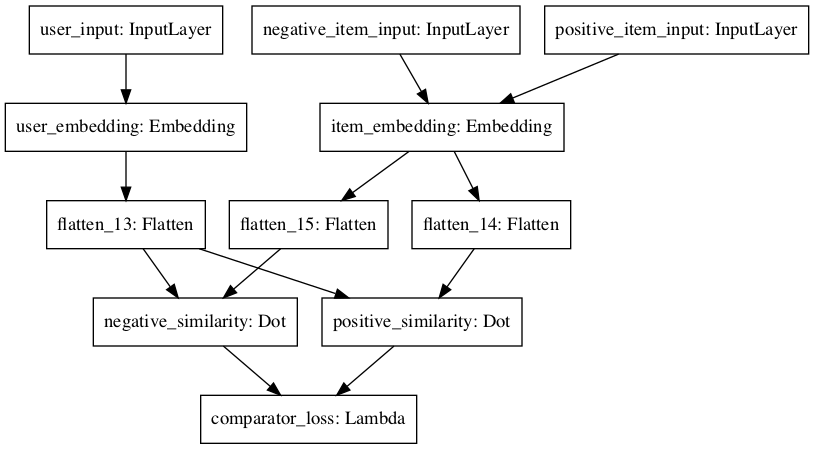

In [41]:
plot_model(triplet_model, to_file='triplet_model.png')
Image(filename='triplet_model.png') 

## Model 2(with deep learning and covariates)

In [42]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dense, Dropout
from keras.layers import Concatenate, Lambda
from keras.regularizers import l2


def make_interaction_mlp(input_dim, n_hidden=1, hidden_size=64,
                         dropout=0, l2_reg=None):
    """
    Build the shared multi layer perceptron

    """
    mlp = Sequential()
    if n_hidden == 0:
        # Plug the output unit directly: this is a simple
        # linear regression model. Not dropout required.
        mlp.add(Dense(1, input_dim=input_dim,
                      activation='relu', kernel_regularizer=l2_reg))
    else:
        mlp.add(Dense(hidden_size, input_dim=input_dim,
                      activation='relu', kernel_regularizer=l2_reg))
        mlp.add(Dropout(dropout))
        for i in range(n_hidden - 1):
            mlp.add(Dense(hidden_size, activation='relu',
                          kernel_regularizer=l2_reg))
            mlp.add(Dropout(dropout))
        mlp.add(Dense(1, activation='relu', kernel_regularizer=l2_reg))
    return mlp


def build_models(n_users, n_items, user_dim=32, item_dim=64,
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=0):
    """
    Build models to train a deep triplet network

    """
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')
    positive_meta_input = Input((2,), name='positive_meta_input')
    negative_meta_input = Input((2,), name='negative_meta_input')

    l2_reg = None if l2_reg == 0 else l2(l2_reg)
    user_layer = Embedding(n_users + 1, user_dim, input_length=1,
                           name='user_embedding', embeddings_regularizer=l2_reg)

    # The following embedding parameters will be shared to encode both
    # the positive and negative items.
    item_layer = Embedding(n_items + 1, item_dim, input_length=1,
                           name="item_embedding", embeddings_regularizer=l2_reg)

    user_embedding = Flatten()(user_layer(user_input))
    positive_item_embedding = Flatten()(item_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_layer(negative_item_input))

    # Similarity computation between embeddings using a MLP similarity
    positive_embeddings_pair = Concatenate(name="positive_embeddings_pair")(
        [user_embedding, positive_item_embedding, positive_meta_input])
    positive_embeddings_pair = Dropout(dropout)(positive_embeddings_pair)

    negative_embeddings_pair = Concatenate(name="negative_embeddings_pair")(
        [user_embedding, negative_item_embedding, negative_meta_input])
    negative_embeddings_pair = Dropout(dropout)(negative_embeddings_pair)

    # Instanciate the shared similarity architecture
    interaction_layers = make_interaction_mlp(
        user_dim + item_dim + 2, n_hidden=n_hidden, hidden_size=hidden_size,
        dropout=dropout, l2_reg=l2_reg)

    positive_similarity = interaction_layers(positive_embeddings_pair)
    negative_similarity = interaction_layers(negative_embeddings_pair)

    # The triplet network model, only used for training
    triplet_loss = Lambda(margin_comparator_loss, output_shape=(1,),
                          name='comparator_loss')(
        [positive_similarity, negative_similarity])

    deep_triplet_model = Model(inputs=[user_input,
                                       positive_item_input,
                                       negative_item_input,
                                       positive_meta_input,
                                       negative_meta_input
                                       ],
                               outputs=[triplet_loss])

    # The match-score model, only used at inference
    deep_match_model = Model(inputs=[user_input, positive_item_input, positive_meta_input],
                             outputs=[positive_similarity])

    return deep_match_model, deep_triplet_model

In [43]:
def sample_triplets(pos_df, items_content, max_items):
    """
    Sample the data and put in the format 
    [user_ids, pos_item_ids, neg_item_ids,pos_item_metadata,neg_item_metadata]

    """
    range_itens = np.arange(max_items)
    user_ids = pos_df['user_id'].values
    

    pos_item_ids = pos_df['item_id_action'].values
    pos_item_metadata = items_content.loc[pos_item_ids][['v3', 'v4']].values

    
    user_pos_items = pos_df.groupby('user_id')['item_id_action'].apply(list)
    neg_item_ids = np.array([])
    for i in user_ids:
        if i in set(user_pos_items.index):
            number = np.random.choice([item for item in range_itens 
                                       if not item in user_pos_items[user_pos_items.index == i]])
        else:
            number = np.random.choice(range_itens, 1)
        neg_item_ids = np.append(neg_item_ids, number)

    neg_item_metadata = items_content.loc[neg_item_ids][['v3', 'v4']].values

    return [user_ids, pos_item_ids, neg_item_ids, pos_item_metadata, neg_item_metadata]

In [44]:
hyper_parameters = dict(
    user_dim=50,
    item_dim=15,
    n_hidden=1,
    hidden_size=16,
    dropout=0.5,
    l2_reg=0
)

In [45]:
number_run = 3
n_epochs = 1
total_reward = 0
generations = 1000
max_items = 30 

for k in range(number_run):

    deep_match_model, deep_triplet_model = build_models(nb_users, nb_items,**hyper_parameters)
    # we plug the identity loss and the a fake target variable ignored by
    # the model to be able to use the Keras API to train the triplet model
    deep_triplet_model.compile(loss=identity_loss, optimizer="adam")
    fake_y = np.ones_like(pos_df['user_id'])
    params = {'user_id': USER_ID}
    
    positive_data = pos_df.copy()
    
    # Training the model 
    for i in range(n_epochs):
        # Sample new negatives to build different triplets at each epoch
        triplet_inputs = sample_triplets(positive_data,items_content, max_items=nb_items)

        # Fit the model incrementally by doing a single pass over the
        # sampled triplets.
        deep_triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                               batch_size=64, epochs=1)


    for j in range(generations):
        
        # Predicting
        new_user_id = next_state[0][0]
        items_ids = np.array([next_state[i][1] for i in range(len(next_state))])
        repeated_user_id = np.empty_like(items_ids)
        repeated_user_id.fill(new_user_id)

        pos_metadata = items_content.loc[items_ids][['v3', 'v4']].values
        predicted = deep_match_model.predict([repeated_user_id, items_ids, pos_metadata])
        predicted_item = np.argmax(predicted)
        params['recommended_item'] = predicted_item

        r = requests.get(url=url_predict, params=params).json()
        reward = r['reward']
        total_reward += reward

        # Online learning
        if(reward > 0):
            range_itens = np.arange(max_items)
            user_pos_items = positive_data.groupby('user_id')['item_id_action'].apply(list)
            if new_user_id in set(user_pos_items.index):
                neg_item_id = np.random.choice([item for item in range_itens 
                                           if not item in user_pos_items[user_pos_items.index == new_user_id]])
            else:
                neg_item_id = np.random.choice(range_itens,1)
            
            pos_item_metadata = items_content.set_index('item_id').loc[predicted_item].values
            neg_item_metadata = items_content.set_index('item_id').loc[neg_item_id].values
            
            triplet_inputs = [[new_user_id], [predicted_item], [neg_item_id], 
                              pos_item_metadata.reshape((1,2)), neg_item_metadata.reshape((1,2))]
    
            fake_y = np.ones_like([1])
            deep_triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                               batch_size = 8, epochs=1)

        next_state = r['state']

print("Total reward: %f and Total reward per run: %f"%(total_reward, total_reward/number_run))

Epoch 1/1
54/54 [==============================] - 1s 12ms/step - loss: 0.9873
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0351
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9307
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0217
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 0.9784
Epoch 1/1

Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 10ms/step - loss: 1.2636
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0020
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9954
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0656
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0288
Epoch 1/1
1

Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9137
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 1.3075
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9550
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1243
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9908
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0387
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9629
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9523
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9011
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9861
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9533
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9199
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0277
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.9937
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1261
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9412
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9337
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8505
Epoch 1/1
1/

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8179
Epoch 1/1
54/54 [==============================] - 1s 15ms/step - loss: 0.9406
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.9995
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.3899
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.7140
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7585
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1673
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8599
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.1160
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8054
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.4097
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.0000
Epoch 1/1

Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.9959
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7042
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0281
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6510
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.7214
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0727
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6669
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0000
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.4943
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.0264
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.2135
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1.5720
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.8986
Epoch 1/1
1/

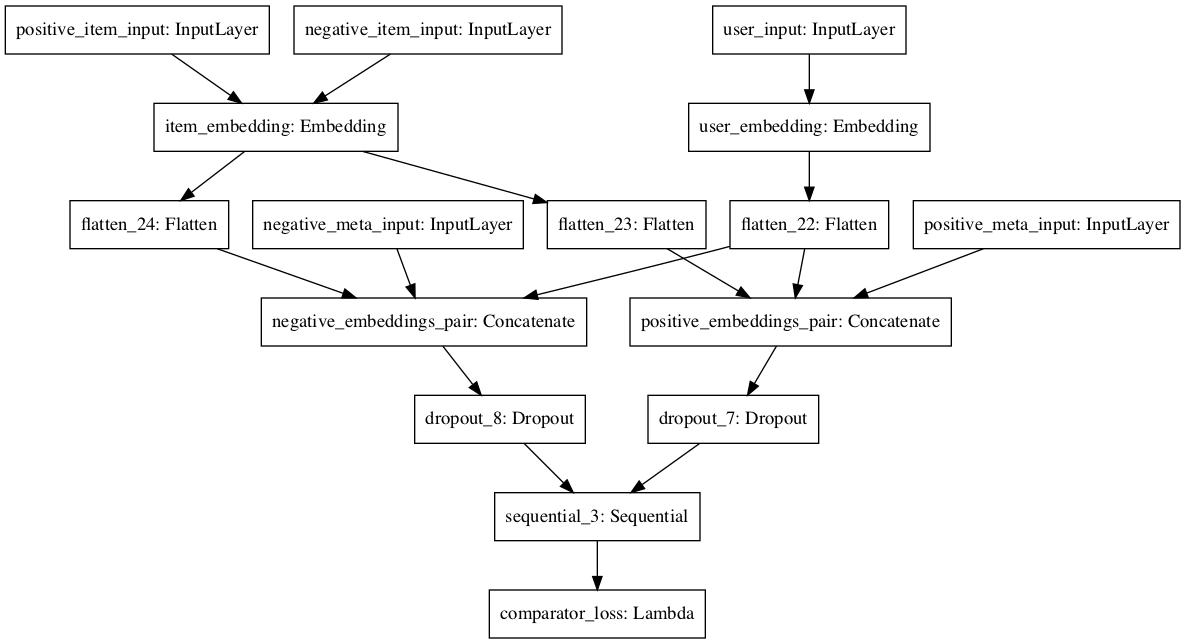

In [46]:
plot_model(deep_triplet_model, to_file='deep_triplet_model.png')
Image(filename='deep_triplet_model.png') 